In [1]:
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.operators.sampling.lhs import LatinHypercubeSampling
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga3 import ReferenceDirectionSurvival
from pymoode.algorithms import NSDER
from pymoode.algorithms import GDE3
from pymoode.survival import RankAndCrowding
from pymoo.util.ref_dirs import get_reference_directions

In [2]:
from pymoo.problems import get_problem
from pymoo.util.plotting import plot

problem = get_problem("dtlz2")

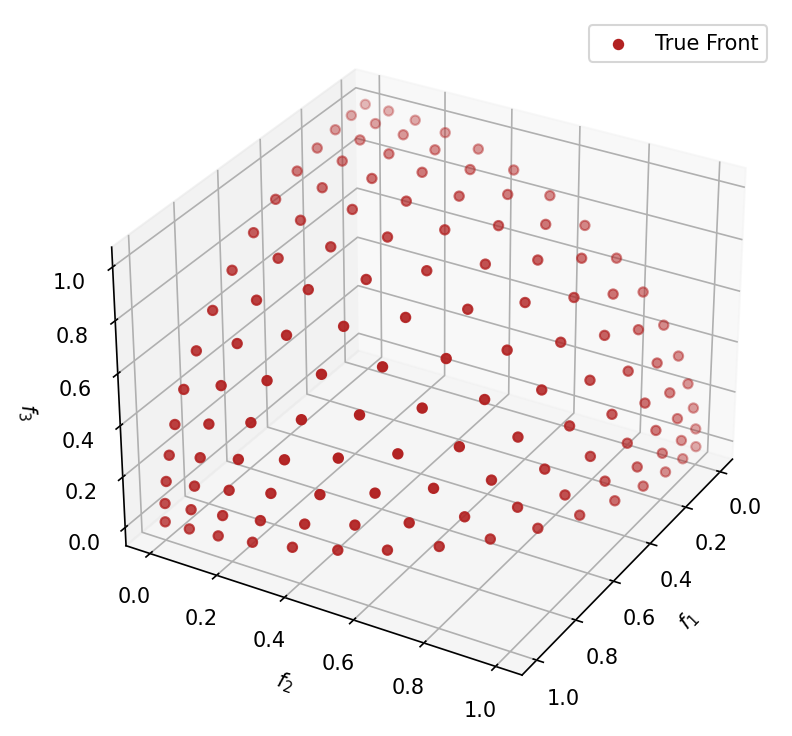

In [3]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})
ax.scatter(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1], problem.pareto_front()[:, 2],
        color="firebrick", label="True Front", marker="o")

ax.view_init(elev=30, azim=30)

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()

In [4]:
NGEN = 250
POPSIZE = 136
SEED = 3

In [5]:
problem.__dict__

{'k': 8,
 'n_var': 10,
 'n_obj': 3,
 'n_ieq_constr': 0,
 'n_eq_constr': 0,
 'data': {},
 'xl': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'xu': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'callback': None,
 'vars': None,
 'vtype': float,
 'elementwise': False,
 'elementwise_func': pymoo.core.problem.ElementwiseEvaluationFunction,
 'elementwise_runner': <pymoo.core.problem.LoopedElementwiseEvaluation at 0x2410138af40>,
 'strict': True,
 'replace_nan_values_by': None,
 'exclude_from_serialization': None,
 'cache': {'pareto_front': array([[0.        , 0.        , 1.        ],
         [0.        , 0.07124705, 0.9974587 ],
         [0.        , 0.15205718, 0.9883717 ],
         [0.        , 0.24253563, 0.9701425 ],
         [0.        , 0.34174306, 0.93979342],
         [0.        , 0.4472136 , 0.89442719],
         [0.        , 0.5547002 , 0.83205029],
         [0.        , 0.65850461, 0.75257669],
         [0.        , 0.75257669, 0.65850461],
         [0.        , 0.8320502

In [6]:
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=15)

In [7]:
ref_dirs.shape

(136, 3)

In [8]:
#This is the pure python implementation of mnn to compare runtime to cython
from pymoode.misc.mnn import calc_mnn

def calc_mnn_nds(F, n_remove: int=0):
    return calc_mnn(F, n_remove=n_remove, twonn=False)

In [9]:
%%time

gde3 = GDE3(pop_size=POPSIZE, variant="DE/rand/1/bin", CR=0.2, F=(0.0, 1.0), gamma=1e-4,
            survival=RankAndCrowding(crowding_func=calc_mnn_nds))

res_gde3 = minimize(problem,
                    gde3,
                    ('n_gen', NGEN),
                    seed=SEED,
                    save_history=True,
                    verbose=True)

n_gen  |  n_eval  | n_nds  |      igd      |       gd     
     1 |      136 |     35 |  0.4095437109 |  0.5012759853
     2 |      272 |     49 |  0.3690051083 |  0.4871520484
     3 |      408 |     50 |  0.3227441314 |  0.4212427562
     4 |      544 |     57 |  0.3003744843 |  0.3922903941
     5 |      680 |     63 |  0.2535874974 |  0.3685596163
     6 |      816 |     75 |  0.2300055999 |  0.3404414329
     7 |      952 |     82 |  0.2086141684 |  0.3042592604
     8 |     1088 |     92 |  0.1974436453 |  0.2770471473
     9 |     1224 |     97 |  0.1818941067 |  0.2620164076
    10 |     1360 |     93 |  0.1654230845 |  0.2169924278
    11 |     1496 |    101 |  0.1456865341 |  0.1961013862
    12 |     1632 |    111 |  0.1323012036 |  0.1754682470
    13 |     1768 |    115 |  0.1235229672 |  0.1592842211
    14 |     1904 |    120 |  0.1178309124 |  0.1442769199
    15 |     2040 |    109 |  0.1088275845 |  0.1125849594
    16 |     2176 |    124 |  0.0964373137 |  0.10749787

In [10]:
%%time

gde3 = GDE3(pop_size=POPSIZE, variant="DE/rand/1/bin", CR=0.2, F=(0.0, 1.0), gamma=1e-4,
            survival=RankAndCrowding(crowding_func="mnn"))

res_gde3 = minimize(problem,
                    gde3,
                    ('n_gen', NGEN),
                    seed=SEED,
                    save_history=True,
                    verbose=True)

n_gen  |  n_eval  | n_nds  |      igd      |       gd     
     1 |      136 |     35 |  0.4095437109 |  0.5012759853
     2 |      272 |     49 |  0.3690051083 |  0.4871520484
     3 |      408 |     50 |  0.3227441314 |  0.4212427562
     4 |      544 |     57 |  0.3003744843 |  0.3922903941
     5 |      680 |     63 |  0.2535874974 |  0.3685596163
     6 |      816 |     75 |  0.2300055999 |  0.3404414329
     7 |      952 |     82 |  0.2086141684 |  0.3042592604
     8 |     1088 |     92 |  0.1974436453 |  0.2770471473
     9 |     1224 |     97 |  0.1818941067 |  0.2620164076
    10 |     1360 |     93 |  0.1654230845 |  0.2169924278
    11 |     1496 |    101 |  0.1456865341 |  0.1961013862
    12 |     1632 |    111 |  0.1323012036 |  0.1754682470
    13 |     1768 |    115 |  0.1235229672 |  0.1592842211
    14 |     1904 |    120 |  0.1178309124 |  0.1442769199
    15 |     2040 |    109 |  0.1088275845 |  0.1125849594
    16 |     2176 |    124 |  0.0964373137 |  0.10749787

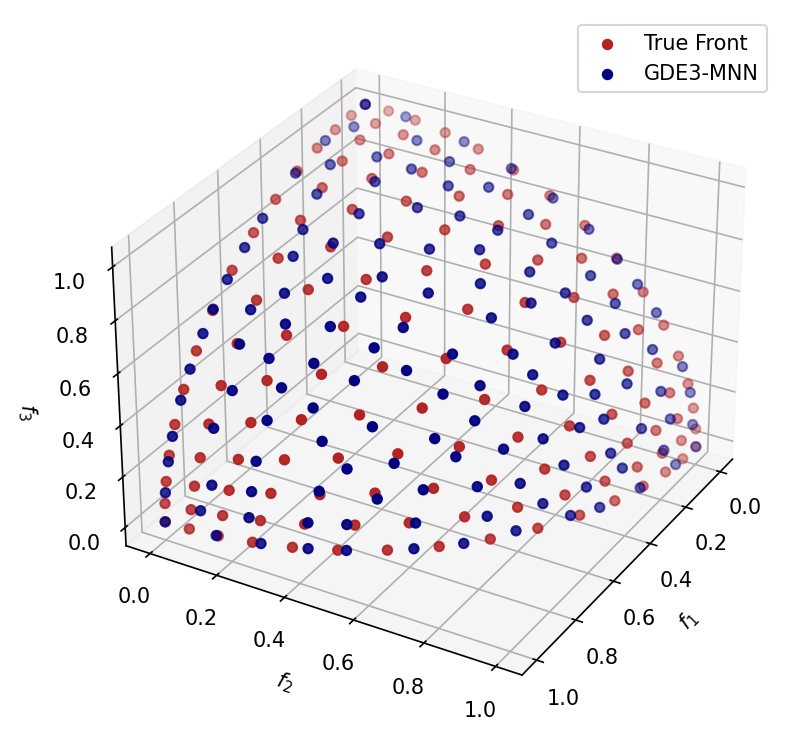

In [11]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})

ax.scatter(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1], problem.pareto_front()[:, 2],
        color="firebrick", label="True Front", marker="o")

ax.scatter(res_gde3.F[:, 0], res_gde3.F[:, 1], res_gde3.F[:, 2],
        color="navy", label="GDE3-MNN", marker="o")

ax.view_init(elev=30, azim=30)

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()

In [12]:
%%time

nsga3 = NSGA3(pop_size=POPSIZE, ref_dirs=ref_dirs)

res_nsga3 = minimize(problem,
                     nsga3,
                     ('n_gen', NGEN),
                     seed=SEED,
                     save_history=True,
                     verbose=True)

n_gen  |  n_eval  | n_nds  |      igd      |       gd     
     1 |      136 |     24 |  0.3936742167 |  0.4467610252
     2 |      272 |     26 |  0.4075333168 |  0.4422173128
     3 |      408 |     32 |  0.3830297639 |  0.4671198493
     4 |      544 |     26 |  0.3063689826 |  0.4013234054
     5 |      680 |     36 |  0.2733802777 |  0.3130311426
     6 |      816 |     41 |  0.2019143127 |  0.2381989840
     7 |      952 |     45 |  0.1806649286 |  0.2226229018
     8 |     1088 |     52 |  0.1699083371 |  0.1924176052
     9 |     1224 |     63 |  0.1681200348 |  0.1821844814
    10 |     1360 |     69 |  0.1466272388 |  0.1537939325
    11 |     1496 |     66 |  0.1372155036 |  0.1330625143
    12 |     1632 |     71 |  0.1297849751 |  0.1268047606
    13 |     1768 |     72 |  0.1244765315 |  0.1158912763
    14 |     1904 |     75 |  0.1132867478 |  0.1046137516
    15 |     2040 |     77 |  0.1106472147 |  0.0985158731
    16 |     2176 |     77 |  0.1029460447 |  0.09018082

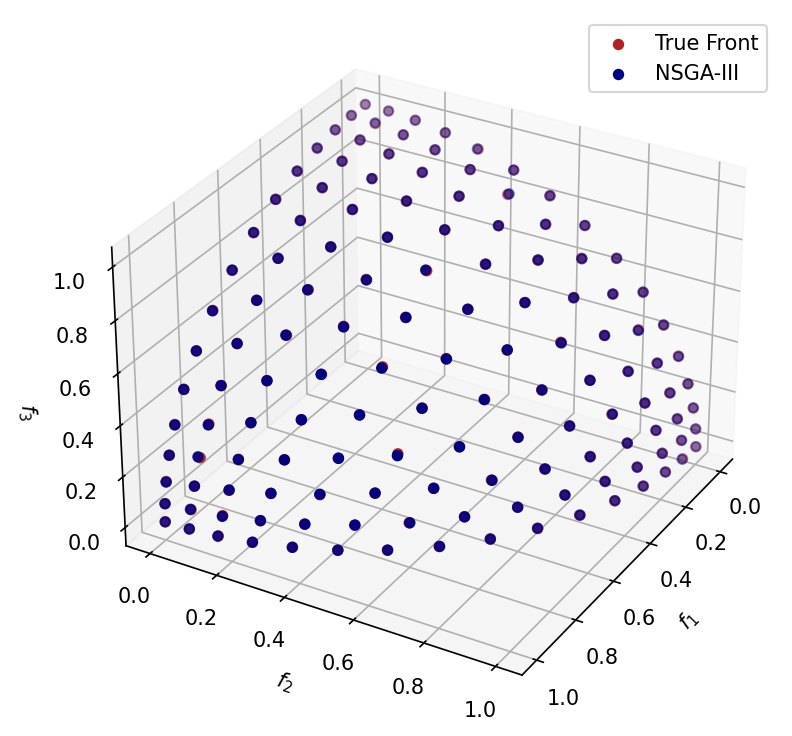

In [13]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})

ax.scatter(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1], problem.pareto_front()[:, 2],
        color="firebrick", label="True Front", marker="o")

ax.scatter(res_nsga3.F[:, 0], res_nsga3.F[:, 1], res_nsga3.F[:, 2],
        color="navy", label="NSGA-III", marker="o")

ax.view_init(elev=30, azim=30)

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()

In [14]:
%%time

nsder = NSDER(ref_dirs=ref_dirs, pop_size=POPSIZE, variant="DE/rand/1/bin", CR=0.5, F=(0.0, 1.0), gamma=1e-4)
    
res_nsder = minimize(problem,
                     nsder,
                     ('n_gen', NGEN),
                     seed=SEED,
                     save_history=True,
                     verbose=True)

n_gen  |  n_eval  | n_nds  |      igd      |       gd     
     1 |      136 |     31 |  0.4095437109 |  0.4887902480
     2 |      272 |     39 |  0.3962624361 |  0.5160147510
     3 |      408 |     43 |  0.3139595711 |  0.4598689871
     4 |      544 |     44 |  0.2783915981 |  0.3771256026
     5 |      680 |     37 |  0.2544581868 |  0.3199476419
     6 |      816 |     36 |  0.2516497909 |  0.3180598195
     7 |      952 |     48 |  0.2021859335 |  0.2779250950
     8 |     1088 |     48 |  0.1999748300 |  0.2330343801
     9 |     1224 |     53 |  0.1879673487 |  0.2186558909
    10 |     1360 |     49 |  0.1712357850 |  0.1682265820
    11 |     1496 |     49 |  0.1754698223 |  0.1564165772
    12 |     1632 |     64 |  0.1402335772 |  0.1499157701
    13 |     1768 |     72 |  0.1346210456 |  0.1397990712
    14 |     1904 |     73 |  0.1156791328 |  0.1205962606
    15 |     2040 |     86 |  0.1045503721 |  0.1026702262
    16 |     2176 |     88 |  0.0952064358 |  0.09089188

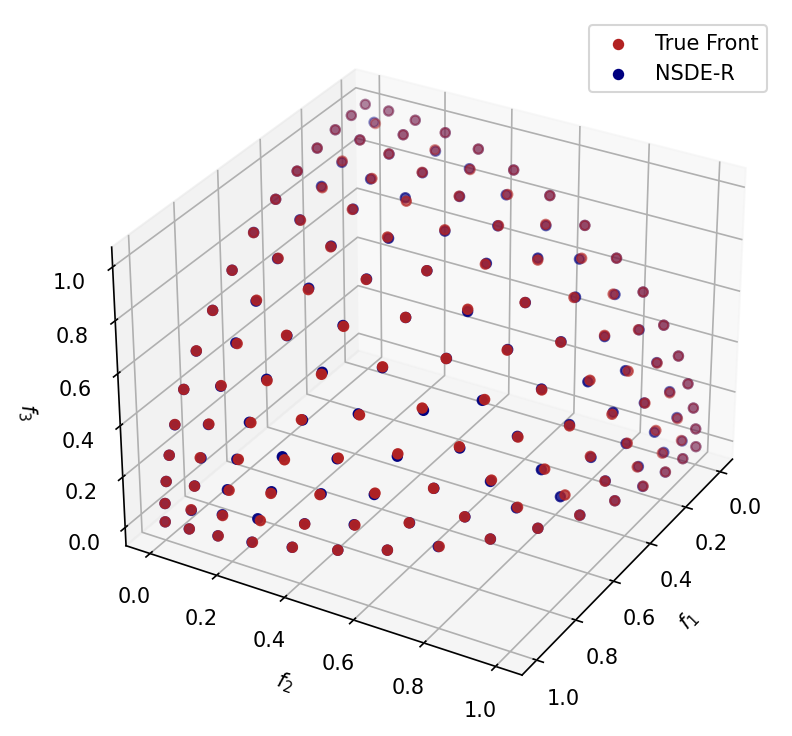

In [15]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})

ax.scatter(problem.pareto_front()[:, 0], problem.pareto_front()[:, 1], problem.pareto_front()[:, 2],
        color="firebrick", label="True Front", marker="o")

ax.scatter(res_nsder.F[:, 0], res_nsder.F[:, 1], res_nsder.F[:, 2],
        color="navy", label="NSDE-R", marker="o")

ax.view_init(elev=30, azim=30)

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()